In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)


In [17]:
class MovieDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        tokenized = self.tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
        return tokenized['input_ids'].squeeze(0), tokenized['attention_mask'].squeeze(0)


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from tqdm import tqdm


class BERT_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BERT_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  
        output = self.fc(lstm_out)
        return output


lstm_model = BERT_LSTM(input_size=768, hidden_size=128, output_size=384).to(device)




In [19]:
df = pd.read_csv('data.csv')  


In [20]:
def generate_embeddings_lstm_bert(texts,tokenizer,bert_model,lstm_model ,batch_size):
    dataset = MovieDataset(texts, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    embeddings = []
    for input_ids, attention_mask in tqdm(dataloader):
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        with torch.no_grad():
            bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            bert_embeddings = bert_outputs.last_hidden_state.mean(dim=1)
            lstm_embeddings = lstm_model(bert_embeddings.unsqueeze(1))
        embeddings.append(lstm_embeddings.cpu().numpy())
    
    return np.vstack(embeddings)

In [21]:

valid_overviews = df['plot'].dropna().tolist()
plot_embeddings = generate_embeddings_lstm_bert(valid_overviews,tokenizer,bert_model,lstm_model,batch_size=32)

  0%|          | 0/1091 [00:00<?, ?it/s]

100%|██████████| 1091/1091 [13:20<00:00,  1.36it/s]


In [22]:
# Genres Encoding
mlb_genres = MultiLabelBinarizer()

df['genre'] = df['genre'].fillna('').apply(    lambda x: [genre.strip() for genre in x.split(',')] if isinstance(x, str) else x)
genres_encoded = mlb_genres.fit_transform(df['genre'])


In [23]:
genres_list=list(mlb_genres.classes_)

movie_embeddings = []

for index, row in tqdm(df.iterrows()):
    movie = {}

    # Genres Extraction
    query_genres = [genre for genre in genres_list if genre.lower() in " ".join(row["genre"]).lower()]
    
    movie["genre"] = np.sum(mlb_genres.transform([query_genres]), axis=0) if query_genres else np.zeros(len(mlb_genres.classes_))

    

    # Overview Embedding (BERT + LSTM)
    embedding_str = row['embeddings'].strip('[]')
    embedding_list = list(map(float, embedding_str.split()))


    embedding_array = np.array(embedding_list)
    
    movie["overview"] = embedding_array
    movie_embeddings.append(movie)

   

34886it [01:54, 304.44it/s]


In [24]:

def generate_query_embedding(query, tokenizer, bert_model, lstm_model, genres_list):
   
    query_embedding = {}

    # Genres Extraction
    query_genres = [genre for genre in genres_list if genre.lower() in query.lower()]
    query_embedding["genre"] = np.sum(mlb_genres.transform([query_genres]), axis=0) if query_genres else np.zeros(len(mlb_genres.classes_))  

    # Overview Embedding (BERT + LSTM)
    query_embedding["overview"] = generate_embeddings_lstm_bert([query], tokenizer, bert_model, lstm_model, batch_size=1).flatten()

    return query_embedding


In [25]:
from scipy.spatial.distance import euclidean

from sklearn.preprocessing import MinMaxScaler


def calculate_similarity(query_embedding, movie_embeddings, weights):
    scaler=MinMaxScaler()
    similarity_scores = []
    
    for movie in movie_embeddings:

        movie['genre'] = scaler.fit_transform(movie['genre'].reshape(-1, 1)).flatten()  
        movie['overview'] = scaler.fit_transform(movie['overview'].reshape(-1, 1)).flatten()


    query_embedding['genre'] = scaler.transform(query_embedding['genre'].reshape(-1, 1)).flatten()
    query_embedding['overview'] = scaler.transform(query_embedding['overview'].reshape(-1, 1)).flatten()
    
    for movie in movie_embeddings:
        
        genres_sim = cosine_similarity([query_embedding["genre"]], [movie["genre"]])[0][0]
        overview_sim = cosine_similarity([query_embedding["overview"]], [movie["overview"]])[0][0]

    
        genres_euclid = euclidean(query_embedding["genre"], movie["genre"])
        overview_euclid = euclidean(query_embedding["overview"], movie["overview"])

        genres_sim_euclid = 1 / (1 + genres_euclid)
        overview_sim_euclid = 1 / (1 + overview_euclid)
        
        total_similarity = (
            weights["genre"] * (genres_sim + genres_sim_euclid) 
        +    weights["overview"] * (overview_sim + overview_sim_euclid)
        )
        
        similarity_scores.append(total_similarity)
    return similarity_scores


In [26]:

def recommend_movies(query, df, embeddings, tokenizer, bert_model, lstm_model, weights,top_n=10):
    
    genres_list=list(mlb_genres.classes_)
    
    
    query_embedding = generate_query_embedding(query, tokenizer, bert_model, lstm_model, genres_list)
    
     
    similarity_scores = calculate_similarity(query_embedding, embeddings, weights)
    df["similarity"] = similarity_scores
    recommended_movies = df.sort_values(by="similarity", ascending=False).head(top_n)
    remaining_movies = df.drop(recommended_movies.index)
    randomly_selected_movies=remaining_movies.sample(10)
    
    recommended_movie_titles = recommended_movies["title"].values
    recommended_movie_embeddings = [embedding for idx, embedding in enumerate(embeddings) if df.iloc[idx]["title"] in recommended_movie_titles]
    random_movie_titles=randomly_selected_movies['title'].values
    randomly_selected_movies=[embedding for idx, embedding in enumerate(embeddings) if df.iloc[idx]["title"] in random_movie_titles]
    visualize_sne(recommended_movie_embeddings,query_embedding,randomly_selected_movies,recommended_movie_titles,random_movie_titles)
    return recommended_movies[["title", "genre", "similarity"]]



In [27]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_sne(movie_embeddings, query_embedding,randomly_selected_movie,recommended_movie_titles,random_movie_titles):
    
    
    movie_num=len(movie_embeddings)
  
    query_embedding = np.array(query_embedding['overview']).reshape(1, -1)
    movie_embeddings = np.array([embedding['overview'] for  embedding in movie_embeddings])  
    randomly_selected_movie=np.array([embedding['overview'] for embedding in randomly_selected_movie])  
    # query embedding+ movie_Embedding
    
    
    combined_embeddings = np.vstack([query_embedding, randomly_selected_movie,movie_embeddings])  

    
    tsne = TSNE(n_components=2, random_state=42, perplexity=12, n_iter=5000)
    
    embeddings_2d = tsne.fit_transform(combined_embeddings)

    df_tsne = pd.DataFrame(embeddings_2d, columns=['tsne1', 'tsne2'])
    df_tsne['type'] = ['query'] + ['movie'] * len(movie_embeddings)  +['random'] * len(randomly_selected_movie)
    plt.scatter(df_tsne.iloc[:10, 0], df_tsne.iloc[:10, 1], label="Random Movies", color="blue", alpha=0.7)
    plt.scatter(df_tsne.iloc[10:15, 0], df_tsne.iloc[10:15, 1], label="Recommended Movies", color="red", alpha=0.7)
    plt.scatter(df_tsne.iloc[-1, 0], df_tsne.iloc[-1, 1], label="Query", color="green")


    for i, title in enumerate(random_movie_titles):
        plt.text(df_tsne.iloc[i, 0], df_tsne.iloc[i, 1], title, fontsize=5)
    for i, title in enumerate(recommended_movie_titles):
        plt.text(df_tsne.iloc[10 + i, 0], df_tsne.iloc[10 + i, 1], title, fontsize=5)
    plt.text(df_tsne.iloc[-1, 0], df_tsne.iloc[-1, 1], 'User input', fontsize=5)    
    plt.legend()
    plt.title('t-SNE Visualization of movies(wiki)', fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()



100%|██████████| 1/1 [00:00<00:00, 45.10it/s]


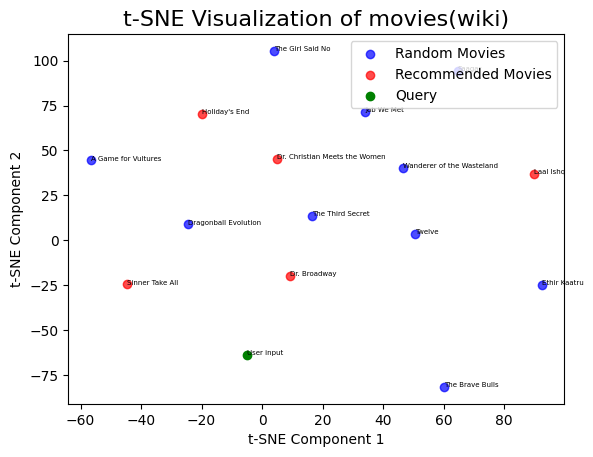

                               title             genre  similarity
2134                 Sinner Take All  [Murder Mystery]    0.546718
28783                      Laal Ishq  [Murder Mystery]    0.543528
18429                  Holiday's End         [Mystery]    0.519831
3292                    Dr. Broadway         [Mystery]    0.515687
2778   Dr. Christian Meets the Women         [Mystery]    0.515636


In [28]:
query = 'British Murder Mystery with detective from scottland yard'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
weights = {"genre": 0.7,  "overview": 0.3} 
recommendations = recommend_movies(query, df, movie_embeddings, tokenizer, bert_model, lstm_model, weights,top_n=5)

print(recommendations)